<a href="https://colab.research.google.com/github/fortune-max/M4-final-hand-gesture-recognition/blob/main/recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
from models.detectors.retinanet import RetinaNet_ResNet50

model = RetinaNet_ResNet50(
    num_classes=20,
    pretrained=False,
    img_mean=[0.54, 0.499, 0.473],
    img_std=[0.231, 0.232, 0.229],
    img_size=224
)
model.type = "detector"
model_state = torch.load("pretrained_models/RetinaNet_ResNet50.pth", map_location=torch.device('cpu'))["MODEL_STATE"]
model.load_state_dict(model_state)
model.eval()

/Users/fortune/code/personal/DS/M4_project/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/fortune/code/personal/DS/M4_project/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/fortune/code/personal/DS/M4_project/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/Users/fortune/code/personal/DS/M4_project/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.LongestMaxSize(max_size=224, p=1),
    A.PadIfNeeded(min_height=224, min_width=224, value=[144, 144, 144], border_mode=0, p=1),
    ToTensorV2()
])

In [41]:
targets = {
    1: "call",
    2: "dislike",
    3: "fist",
    4: "four",
    5: "like",
    6: "mute",
    7: "ok",
    8: "one",
    9: "palm",
    10: "peace",
    11: "rock",
    12: "stop",
    13: "stop inverted",
    14: "three",
    15: "two up",
    16: "two up inverted",
    17: "three2",
    18: "peace inverted",
    19: "no gesture",
}

In [48]:
import cv2
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

def get_img_from_camera():
    cam = cv2.VideoCapture(0)
    ret, frame = cam.read()
    cam.release()
    if ret:
        return frame

def get_img_from_file(path):
    return cv2.imread(path)

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img.shape[0], img.shape[1]
    transformed_image = transform(image=img)
    processed_image = transformed_image["image"] / 255.0
    return processed_image, (width, height)

def permute_processed_image(img):
    return img.permute(1, 2, 0)

53 found
Gesture: call, confidence: 0.2546190619468689


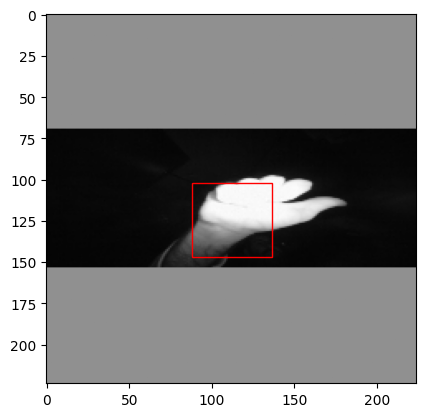

In [72]:
min_num_hands = 1

for i in range(1):
    frame = get_img_from_file("sample_images/thumbs_1.png")
    processed_image, (width, height) = preprocess_image(frame)

    with torch.no_grad():
        output = model([processed_image])[0]
    print(len(output["boxes"]), "found")
    fig, ax = plt.subplots(1)
    ax.imshow(permute_processed_image(processed_image))
    for (box, score, label) in zip(output["boxes"], output["scores"], output["labels"]):
        ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none'))
        print(f"Gesture: {targets[label.item()+1]}, confidence: {score.item()}")
        break
    plt.show()
    

In [55]:
%debug

> /var/folders/zg/95x_7ysx1vx7x6tt_gpw6dp00000gn/T/ipykernel_55574/1801652701.py(16)<module>()
     14         ax.add_patch(Rectangle((boxes[0], boxes[1]), boxes[2]-boxes[0], boxes[3]-boxes[1], linewidth=1, edgecolor='r', facecolor='none'))
     15         # show label and score
---> 16         print(targets[labels], scores)
     17 
     18         break

tensor(4)
*** NameError: name 'target' is not defined
{0: 'wut', 1: 'call', 2: 'dislike', 3: 'fist', 4: 'four', 5: 'like', 6: 'mute', 7: 'ok', 8: 'one', 9: 'palm', 10: 'peace', 11: 'rock', 12: 'stop', 13: 'stop inverted', 14: 'three', 15: 'two up', 16: 'two up inverted', 17: 'three2', 18: 'peace inverted', 19: 'no gesture'}
*** KeyError: tensor(4)
*** KeyError: tensor(4)
*** KeyError: tensor(4)
*** KeyError: tensor(4)


In [ ]:

    # for i in range(min(min_num_hands, len(boxes))):
    #     if scores[i] > 0.8:
    #         scale = max(width, height) / conf.LongestMaxSize.max_size
    #         padding_w = abs(224 - width // scale) // 2
    #         padding_h = abs(224 - height // scale) // 2
    #         x1 = int((boxes[i][0] - padding_w) * scale)
    #         y1 = int((boxes[i][1] - padding_h) * scale)
    #         x2 = int((boxes[i][2] - padding_w) * scale)
    #         y2 = int((boxes[i][3] - padding_h) * scale)
    #         cv2.rectangle(frame, (x1, y1), (x2, y2), COLOR, thickness=3)
    #         cv2.putText(
    #             frame,
    #             targets[int(labels[i]) + 1],
    #             (x1, y1 - 10),
    #             cv2.FONT_HERSHEY_SIMPLEX,
    #             2,
    #             (0, 0, 255),
    #             thickness=3,
    #         )
    
    # cv2.putText(frame, (30, 30), "ct i",  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # from PIL import Image
    # display(Image.fromarray(frame))

    # key = cv2.waitKey(1)
    # if True:
    #     from time import sleep
    #     sleep(5)
    #     cam.release()
    #     cv2.destroyAllWindows()
    #     break

In [24]:
%debug

> /Users/fortune/code/personal/DS/M4_project/env/lib/python3.11/site-packages/matplotlib/image.py(693)_normalize_image_array()
    691             A = A.squeeze(-1)  # If just (M, N, 1), assume scalar and apply colormap.
    692         if not (A.ndim == 2 or A.ndim == 3 and A.shape[-1] in [3, 4]):
--> 693             raise TypeError(f"Invalid shape {A.shape} for image data")
    694         if A.ndim == 3:
    695             # If the input data has values outside the valid range (after

*** NameError: name 'output' is not defined
['A']
> /Users/fortune/code/personal/DS/M4_project/env/lib/python3.11/site-packages/matplotlib/image.py(723)set_data()
    721         if isinstance(A, PIL.Image.Image):
    722             A = pil_to_array(A)  # Needed e.g. to apply png palette.
--> 723         self._A = self._normalize_image_array(A)
    724         self._imcache = None
    725         self.stale = True

> /Users/fortune/code/personal/DS/M4_project/env/lib/python3.11/site-packages/matplotl